In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import sys

sys.path.append("../scripts")
from LSTM import PortfolioPredicitionsLSTM_value

# Import des données

In [6]:
titres = {#"Apple": pd.read_csv("../data/AAPL.csv"),
          "Amazon": pd.read_csv("../data/AMZN.csv"),
          "Berkshire": pd.read_csv("../data/BRK-B.csv"),
          "Google": pd.read_csv("../data/GOOG.csv"),
          "Meta":  pd.read_csv("../data/META.csv"),
          "Microsoft": pd.read_csv("../data/MSFT.csv"),
          #"Nvidia": pd.read_csv("../data/NVDA.csv"),
          #"Tesla": pd.read_csv("../data/TSLA.csv"),
          #"UnitedHealth": pd.read_csv("../data/UNH.csv"),
          "Exxon": pd.read_csv("../data/XOM.csv")}

# Modélisation

In [7]:
LSTM = PortfolioPredicitionsLSTM_value(titres, 30, 50)

In [8]:
predictions, ptf_avg = LSTM.predict_avg_portfolio()

100%|██████████| 6/6 [03:33<00:00, 35.57s/it]


# Résultats

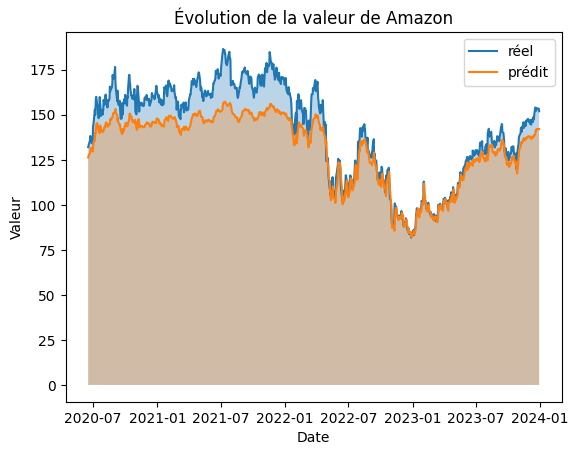

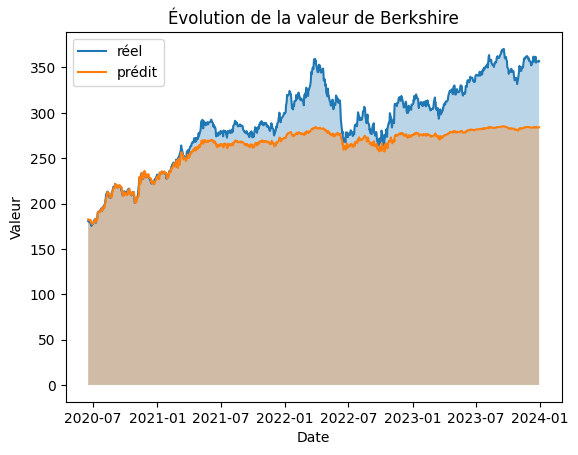

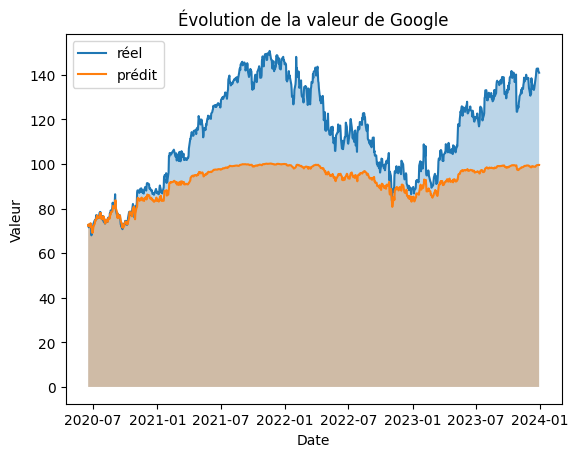

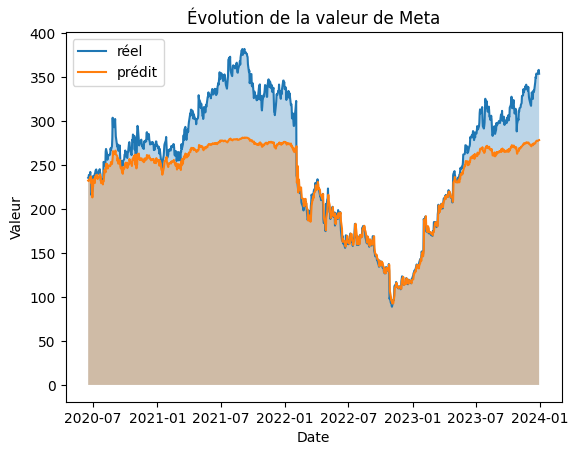

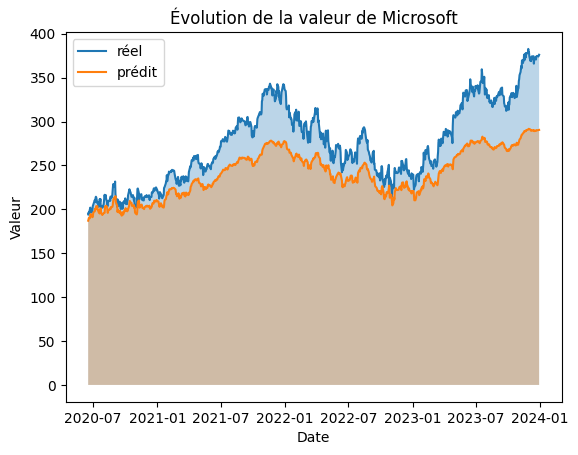

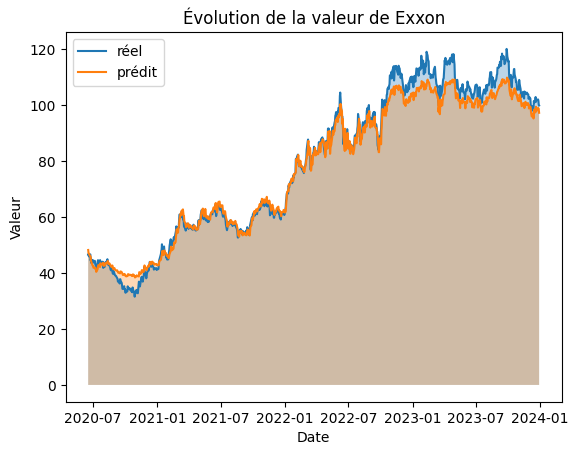

In [11]:
for key, value in predictions.items() :
    plt.plot(value.Date, value['Close'], label='réel')
    plt.fill_between(value.Date, value['Close'], alpha=0.3)
    
    # Plot the 'Prediction' values
    plt.plot(value.Date, value['Prediction'], label='prédit')
    plt.fill_between(value.Date, value['Prediction'], alpha=0.3)
    
    # Set the title and axis labels
    plt.title(f"Évolution de la valeur de {key}")
    plt.xlabel('Date')
    plt.ylabel('Valeur')
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()

In [12]:
fig = go.Figure()

# Ajout de la série financière
fig.add_trace(go.Scatter(x = ptf_avg.Date, 
                         y = ptf_avg['Real_Portfolio_Value'],
                         mode = 'lines',
                         name ='réel', 
                         fill = "tozeroy"))

fig.add_trace(go.Scatter(x = ptf_avg.Date, 
                         y = ptf_avg['Predicted_Portfolio_Value'],
                         mode = 'lines',
                         name ='prédit', 
                         fill = "tozeroy"))

# Mise à jour des titres
fig.update_layout(title="Évolution de la valeur de ptf",
                  xaxis_title='Date',
                  yaxis_title='Valeur')

# Affichage du graphique
fig.show()